<a href="https://colab.research.google.com/github/opencoca/dalle-mini/blob/main/tools/inference/inference_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DALL·E mini - Inference pipeline

*Generate images from text prompt(s)*

This notebook streamlines the [DALL·E mini](https://github.com/borisdayma/dalle-mini) inference pipeline.

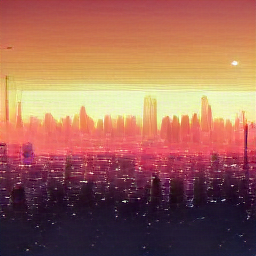

Just want to play? Try the [web app](https://www.craiyon.com/).

For more understanding of the model, refer to [the report](https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-mini--Vmlldzo4NjIxODA).

## 🛠️ Installation and set-up

In [27]:
#@markdown Install required libraries
from IPython.display import clear_output
from termcolor import colored
print(colored("Installing!", "blue"))
!pip install -q dalle-mini  --quiet
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git  --quiet
!git clone https://github.com/opencoca/dalle-mini --quiet
clear_output()
print(colored("Installing!", "blue"))

#@markdown We load required models:
#@markdown * DALL·E mini for text to encoded images
#@markdown * VQGAN for decoding images
#@markdown * CLIP for scoring predictions

# Model references

# dalle-mega
DALLE_MODEL = "dalle-mini/dalle-mini/mega-1-fp16:latest"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
DALLE_COMMIT_ID = None

# if the notebook crashes too often you can use dalle-mini instead by uncommenting below line
# DALLE_MODEL = "dalle-mini/dalle-mini/mini-1:v0"

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

clear_output()
print(colored("Instalation of required libraries DONE!", "green"))
import jax
import jax.numpy as jnp

# check how many devices are available
print(colored( str(jax.local_device_count()) + " Local render devices found.", "green"))

#@markdown Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

# Load dalle-mini
model, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)

# Load VQGAN
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)

clear_output()
print(colored("Loaded dalle-mini and VQGAN!", "green"))

print(colored("Model parameters are replicated on each device for faster inference.", "blue"))
from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

print(colored("Model functions are compiled and parallelized to take advantage of multiple devices.", "blue"))
from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

print(colored("Keys are passed to the model on each device to generate unique inference per device.", "green"))
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)


#Our model requires processing prompts.
from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

Loaded dalle-mini and VQGAN!
Model parameters are replicated on each device for faster inference.
Model functions are compiled and parallelized to take advantage of multiple devices.
Keys are passed to the model on each device to generate unique inference per device.


wandb: Downloading large artifact mega-1-fp16:latest, 4938.53MB. 7 files... Done. 0:0:40.8


## 🎨 Generate images

We generate images using dalle-mini model and decode them with the VQGAN.

Prompts: ['A cyberpunk illustration of the San Francisco Golden Gate Bridge, digital art - 4k desktop wallpaper ', 'A cyberpunk illustration of London Bridge, digital art - 4k desktop wallpaper ', 'A knife sticking into ground in Ancient Egypt, Cinematic shot, Highly Detailed - 4k desktop wallpaper ', 'A knife sticking into ground in Ancient Rome, Cinematic shot, Highly Detailed - 4k desktop wallpaper ']



  0%|          | 0/4 [00:00<?, ?it/s]

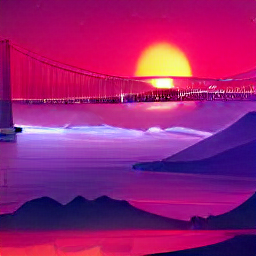

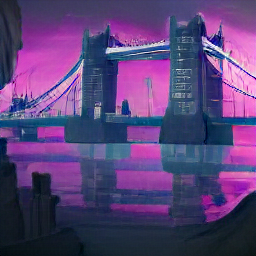

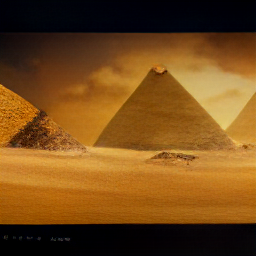

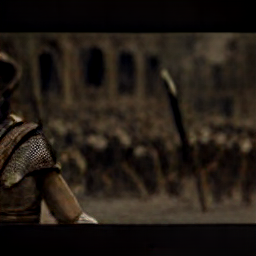

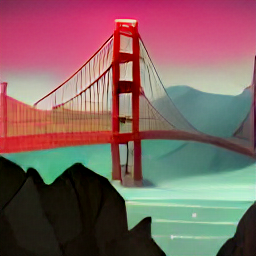

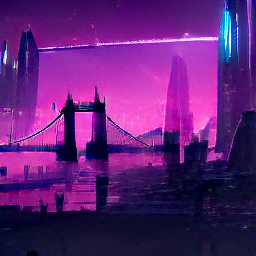

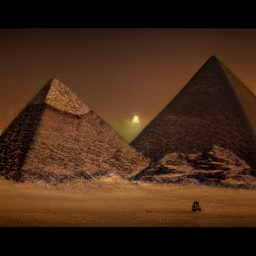

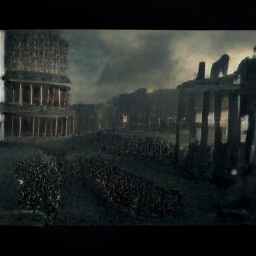

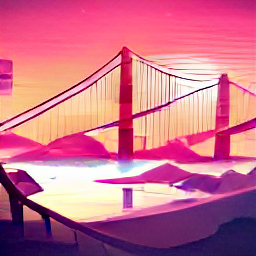

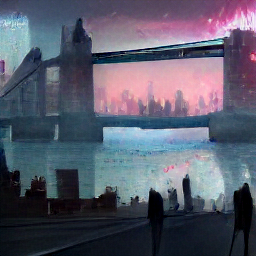

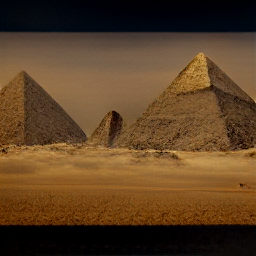

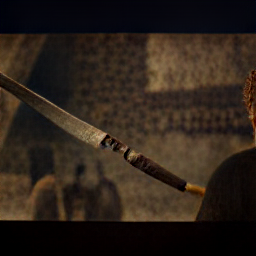

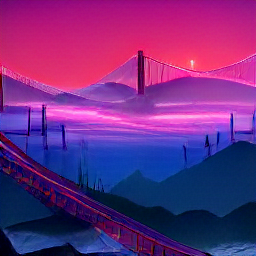

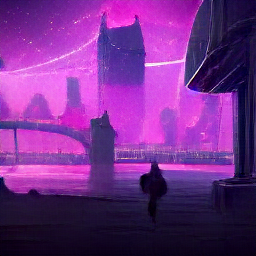

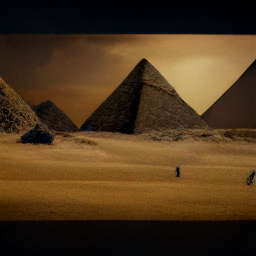

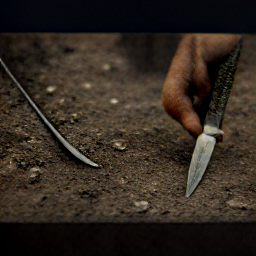

In [33]:
#@markdown ## 🖼 Text Prompt(s) 
#@markdown ###### and optional 📻 tuning
# number of predictions per prompt
n_predictions = 4

# We can customize generation parameters (see https://huggingface.co/blog/how-to-generate)
gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0

#@markdown Let's define some text prompts.
prompt_1 = "A cyberpunk illustration of the San Francisco Golden Gate Bridge, digital art - 4k desktop wallpaper " #@param {type:"string"}
prompt_2 = "A cyberpunk illustration of London Bridge, digital art - 4k desktop wallpaper " #@param {type:"string"}
prompt_3 = "A knife sticking into ground in Ancient Egypt, Cinematic shot, Highly Detailed - 4k desktop wallpaper " #@param {type:"string"}
prompt_4 = "A knife sticking into ground in Ancient Rome, Cinematic shot, Highly Detailed - 4k desktop wallpaper " #@param {type:"string"}

prompts = [
    prompt_1,
    prompt_2,
    prompt_3,
    prompt_4,
]
#:Note: we could use the same prompt multiple times for faster inference.
tokenized_prompts = processor(prompts)
# Finally we replicate the prompts onto each device.
tokenized_prompt = replicate(tokenized_prompts)


from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange

print(f"Prompts: {prompts}\n")
# generate images
images = []
for i in trange(max(n_predictions // jax.device_count(), 1)):
    # get a new key
    key, subkey = jax.random.split(key)
    # generate images
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(subkey),
        params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    # remove BOS
    encoded_images = encoded_images.sequences[..., 1:]
    # decode images
    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    for decoded_img in decoded_images:
        img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
        images.append(img)
        display(img)
        print()

## 🪄 Optional: Save your Generated Images as W&B Tables

W&B Tables is an interactive 2D grid with support to rich media logging. Use this to save the generated images on W&B dashboard and share with the world.

In [34]:
import wandb

# Initialize a W&B run.
project = 'dalle-mini-tables-colab'
run = wandb.init(project=project)

# Initialize an empty W&B Tables.
columns = ["captions"] + [f"image_{i+1}" for i in range(n_predictions)]
gen_table = wandb.Table(columns=columns)

# Add data to the table.
for i, prompt in enumerate(prompts):
    tmp_imgs = images[i::len(prompts)]

    # Add the data to the table.
    gen_table.add_data(prompt, *[wandb.Image(img) for img in tmp_imgs])

# Log the Table to W&B dashboard.
wandb.log({"Generated Images": gen_table})

# Close the W&B run.
run.finish()

Click on the link above to check out your generated images.